In [1]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from PIL import Image
import pathlib

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cuda')
print(device)

cuda


In [3]:
import yaml

with open("C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/data.yaml", 'r') as f:
    data_structure = yaml.safe_load(f)
    print(data_structure)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 7, 'names': ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive'], 'roboflow': {'workspace': 'veda', 'project': 'bone-fracture-detection-daoon', 'version': 4, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/veda/bone-fracture-detection-daoon/dataset/4'}}


In [4]:
os.listdir('C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/')

['data.yaml', 'README.dataset.txt', 'test', 'train', 'valid']

In [5]:
image_path = Path('C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/')

In [6]:
import os
def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
class_names = data_structure['names']
class_names

['elbow positive',
 'fingers positive',
 'forearm fracture',
 'humerus fracture',
 'humerus',
 'shoulder fracture',
 'wrist positive']

In [8]:
class_names.append('Normal')
class_names

['elbow positive',
 'fingers positive',
 'forearm fracture',
 'humerus fracture',
 'humerus',
 'shoulder fracture',
 'wrist positive',
 'Normal']

In [9]:
class_names[7]

'Normal'

torch.Size([3, 1024, 1024])


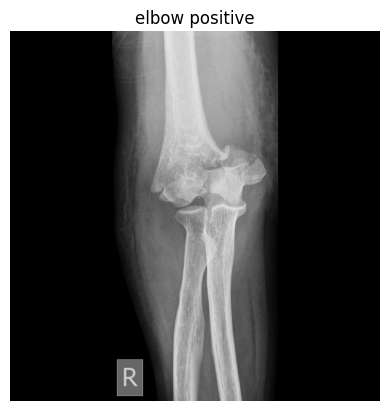

In [10]:
train_image_path = Path(image_path)/'train/images'
train_label_path = Path(image_path)/'train/labels'

transform = transforms.ToTensor()

for i in train_image_path.glob('*'):
    file = i.stem
    label_correspond = f"{file}.txt"
    label = train_label_path / label_correspond

    with open(label, 'r') as label_file:
        label_values = label_file.read().split(' ')
        label = label_values[0]

    image_file = Image.open(i)
    image_tensor = transform(image_file)

    print(image_tensor.size())
    plt.imshow(image_tensor.permute(1,2,0))
    plt.title(class_names[int(label)])
    plt.axis("off")
    plt.show()
    break

In [11]:
import torchvision.transforms as transforms

data_transform = transforms.Compose([ 
    transforms.Resize((128, 128)), 
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),  
    transforms.ToTensor(),  
])


In [12]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),  
    transforms.ToTensor(),  
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

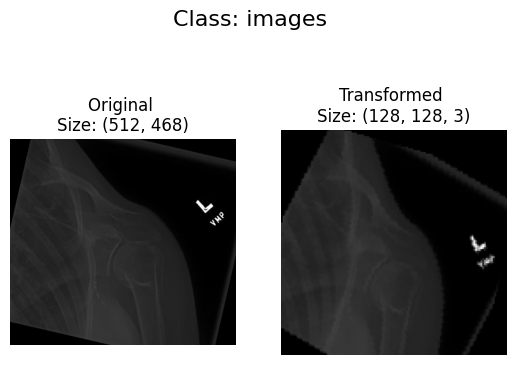

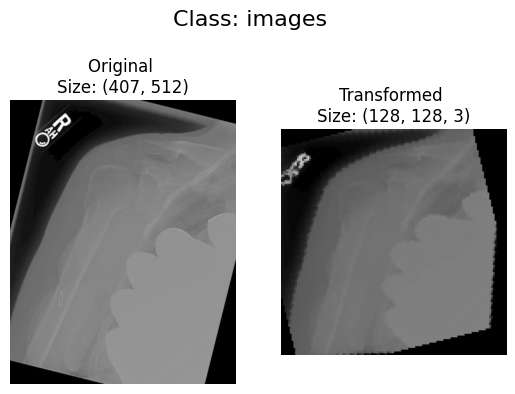

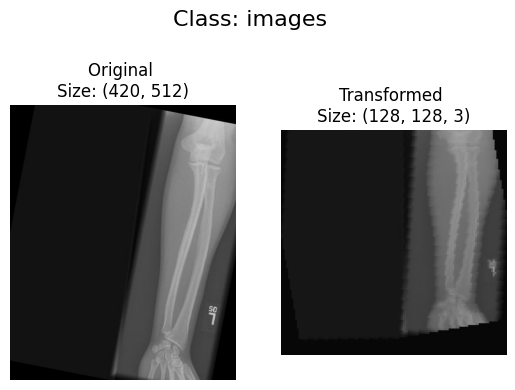

In [13]:
import random
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_paths in random_image_paths:
        with Image.open(image_paths) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f)
            if isinstance(transformed_image, torch.Tensor):
                transformed_image = transformed_image.permute(1, 2, 0).numpy()
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_paths.parent.stem}", fontsize=16)

image_path_list = list(image_path.glob("*/*/*.jpg"))
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)


In [14]:
train_image_path = Path(image_path/'train/images')
train_label_path = Path(image_path/'train/labels')

valid_image_path = pathlib.Path(image_path/'valid/images')
valid_label_path = pathlib.Path(image_path/'valid/labels')


test_image_path = pathlib.Path(image_path/'test/images')
test_label_path = pathlib.Path(image_path/'test/labels')

train_image_path, test_image_path, valid_image_path

(WindowsPath('C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/train/images'),
 WindowsPath('C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/test/images'),
 WindowsPath('C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/valid/images'))

In [15]:
from pathlib import Path

for folder in image_path.iterdir():
    if folder.is_dir():
        print(f"Directory: {folder.name}")
        for file in folder.iterdir():
            print(f"  File: {file.name}")


Directory: test
  File: images
  File: labels
Directory: train
  File: images
  File: labels
Directory: valid
  File: images
  File: labels


In [16]:
import os
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset

def validate_label(label, num_classes):
    """Ensure label is within the valid range of class indices."""
    if label < 0 or label >= num_classes:
        return 0  
    return label

class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, default_label=7):
        self.image_dir = Path(image_dir)
        self.label_dir = Path(label_dir)
        self.transform = transform
        self.default_label = default_label
        self.num_classes = 8
        
        self.image_files = sorted(self.image_dir.glob('*.jpg'))
        self.label_files = sorted(self.label_dir.glob('*.txt'))
        
        assert len(self.image_files) == len(self.label_files), \
            "Mismatch between number of images and label files."
        
        if len(self.image_files) == 0:
            raise ValueError("No image files found in the specified directory.")
        if len(self.label_files) == 0:
            raise ValueError("No label files found in the specified directory.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        label_path = self.label_dir / (img_path.stem + '.txt')

        if not label_path.exists():
            label = self.default_label
        else:
            with open(label_path, 'r') as f:
                label_data = f.read().strip().split(' ')
                try:
                    label = int(label_data[0]) if label_data else self.default_label
                except ValueError:
                    label = self.default_label
        
        label = validate_label(label, self.num_classes) 
        

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label 
    

train_dataset = ImageLabelDataset(
    image_dir='C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/train/images',
    label_dir='C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/train/labels',
    transform=train_transforms
)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
)


In [17]:
test_dataset = ImageLabelDataset(
    image_dir='C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/test/images',
    label_dir='C:/Users/Mahesh/Downloads/archive_unzipped/BoneFractureYolo8/test/labels',
    transform=test_transforms

)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [18]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x22ddd91e4d0>,
 <torch.utils.data.dataloader.DataLoader at 0x22ddd973e10>)

In [19]:
from sklearn.metrics import accuracy_score
import torch.utils.data
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train() 
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  

        outputs = model(images)
        loss = loss_fn(outputs, labels) 
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        _, preds = torch.max(outputs, 1) 
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def test_step(model: torch.nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval() 
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels) 
            running_loss += loss.item() * images.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(test_dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc


In [20]:
from tqdm.auto import tqdm
import torch.utils.data

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
    model.to(device) 

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           train_dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        test_dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.8f} | train_acc: {train_acc:.8f} | test_loss: {test_loss:.8f} | test_acc: {test_acc:.8f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


c:\Users\Mahesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


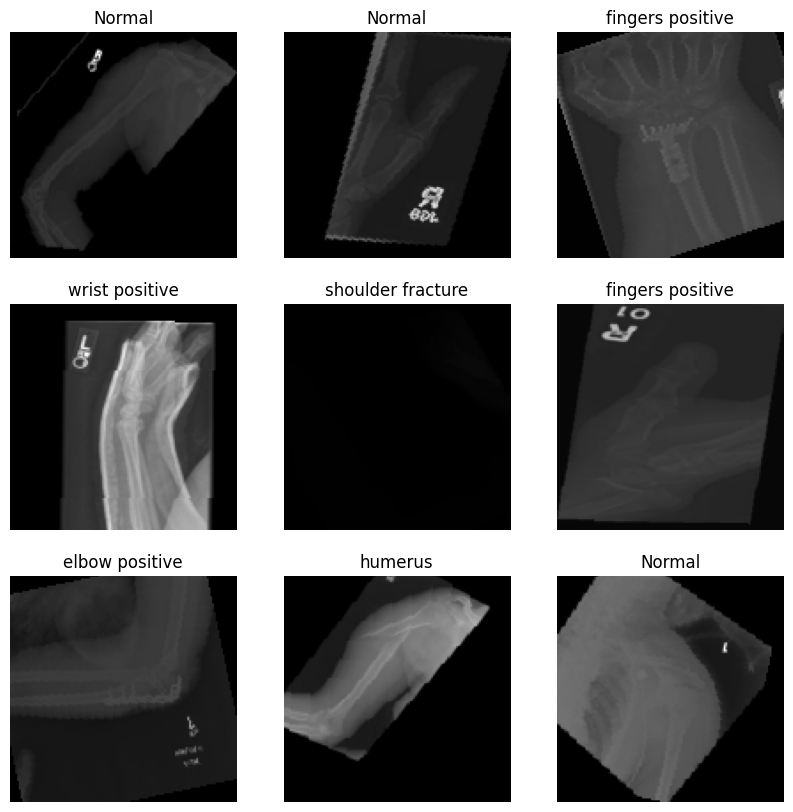

In [21]:
plt.figure(figsize=(10, 10))
for imagess, labelss in train_dataloader:
    batch_size = imagess.size(0)
    for i in range(min(9, batch_size)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(imagess[i].permute(1, 2, 0).numpy())
        plt.title(class_names[labelss[i].item()])
        plt.axis("off")
    break


In [22]:
from torchvision import models

model_3 = models.resnet50(pretrained=True).to(device)

num_classes = len(class_names)
model_3.fc = nn.Linear(model_3.fc.in_features, num_classes)

c:\Users\Mahesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
dummy_input = torch.randn(32, 3, 128, 128)
try:
    output = model_3(dummy_input).to(device)
    print("Forward pass successful. Output shape:", output.shape)
except Exception as e:
    print("Error in forward pass:", str(e))

Error in forward pass: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor


In [24]:
from torchinfo import summary

summary(model_3, input_size=[32, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 8]                   --
├─Conv2d: 1-1                            [32, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [32, 64, 64, 64]          128
├─ReLU: 1-3                              [32, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [32, 64, 32, 32]          --
├─Sequential: 1-5                        [32, 256, 32, 32]         --
│    └─Bottleneck: 2-1                   [32, 256, 32, 32]         --
│    │    └─Conv2d: 3-1                  [32, 64, 32, 32]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 32, 32]          128
│    │    └─ReLU: 3-3                    [32, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [32, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 32, 32]          128
│    │    └─ReLU: 3-6                    [32, 64, 32, 32]          --
│ 

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3.fc.to(device)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=criterion,
                        epochs=8,
                        device=device)



 12%|█▎        | 1/8 [01:26<10:06, 86.68s/it]

Epoch: 1 | train_loss: 33.82342855 | train_acc: 0.60121179 | test_loss: 23.68968775 | test_acc: 0.64497041


 25%|██▌       | 2/8 [03:02<09:10, 91.78s/it]

Epoch: 2 | train_loss: 18.13460169 | train_acc: 0.77416690 | test_loss: 26.20810548 | test_acc: 0.62721893


 38%|███▊      | 3/8 [04:33<07:37, 91.59s/it]

Epoch: 3 | train_loss: 11.87836697 | train_acc: 0.85568714 | test_loss: 23.69155196 | test_acc: 0.73372781


 50%|█████     | 4/8 [05:58<05:56, 89.15s/it]

Epoch: 4 | train_loss: 9.30400375 | train_acc: 0.89451942 | test_loss: 34.02052863 | test_acc: 0.62130178


 62%|██████▎   | 5/8 [07:28<04:27, 89.28s/it]

Epoch: 5 | train_loss: 7.48247262 | train_acc: 0.92095841 | test_loss: 30.91271625 | test_acc: 0.67455621


 75%|███████▌  | 6/8 [09:14<03:10, 95.08s/it]

Epoch: 6 | train_loss: 5.46782360 | train_acc: 0.93775819 | test_loss: 30.15108114 | test_acc: 0.72781065


 88%|████████▊ | 7/8 [11:08<01:41, 101.19s/it]

Epoch: 7 | train_loss: 5.09143942 | train_acc: 0.94574497 | test_loss: 35.70606975 | test_acc: 0.66272189


100%|██████████| 8/8 [12:44<00:00, 95.52s/it] 

Epoch: 8 | train_loss: 3.94706993 | train_acc: 0.95868907 | test_loss: 39.76697922 | test_acc: 0.65680473


In [26]:
dataiter = iter(test_dataloader)
inputs, labels = next(dataiter)
inputs, labels = inputs.to(device), labels.to(device)

outputs = model_3(inputs)

print("Output shape:", outputs.shape) 


Output shape: torch.Size([32, 8])


In [27]:
def plot_loss_curves(results: dict[str, list[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

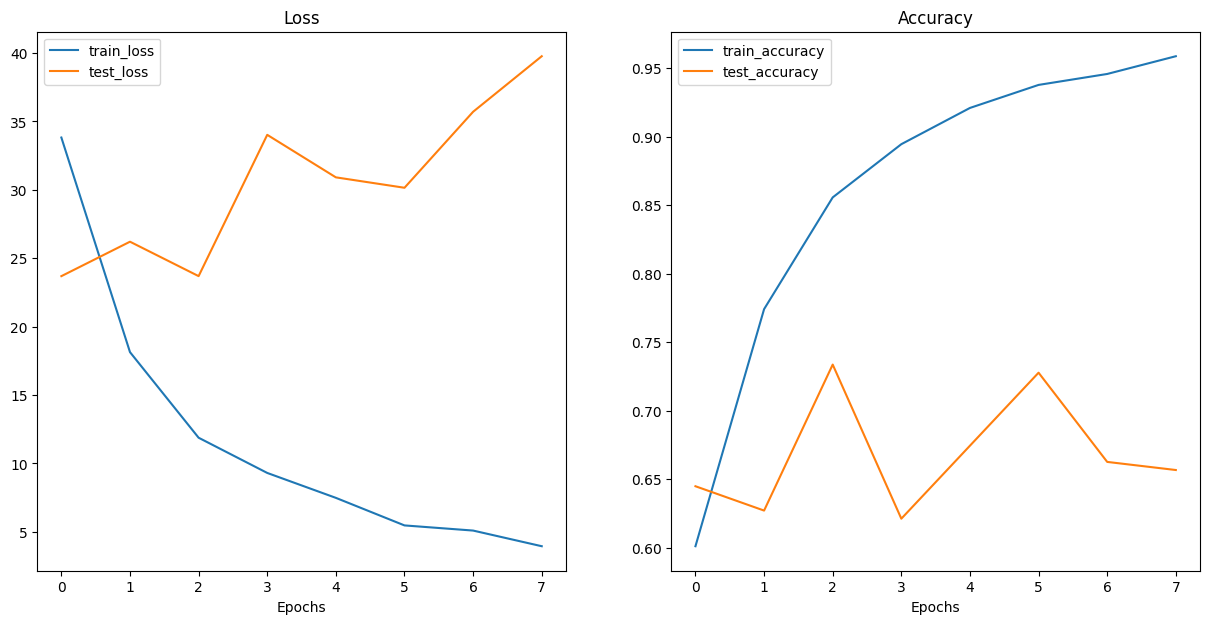

In [28]:
plot_loss_curves(model_3_results)

In [29]:
import torch

torch.save(model_3.state_dict(), 'model_3.pth')

torch.save(model_3, 'model_3_full.pth')


In [31]:
# import torch
# import torchvision.models as models

# loaded_model_3 = models.resnet50(pretrained=True).to(device)
# loaded_model_3.load_state_dict(torch.load('model_3.pth'))
# loaded_model_3.eval() 

# # To load the entire model
# model_3_full = torch.load('model_3_full.pth')
# model_3_full.eval()  


In [33]:
dataiter = iter(test_dataloader)
inputs, labels = next(dataiter)
inputs, labels = inputs.to(device), labels.to(device)

outputs = model_3(inputs)

print("Output shape:", outputs.shape) 


Output shape: torch.Size([32, 8])


In [ ]:
from torchvision import models
import torch.nn as nn

model_3 = models.resnet50(pretrained=True)

num_classes = 8
model_3.fc = nn.Linear(model_3.fc.in_features, num_classes)

print(model_3)

c:\Users\Mahesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
dataiter = iter(test_dataloader)
inputs, labels = next(dataiter)
inputs, labels = inputs.to(device), labels.to(device)

outputs = model_3(inputs)

print("Output shape:", outputs.shape) 


Output shape: torch.Size([32, 8])


In [37]:
from torchinfo import summary

summary(model_3, input_size=[32, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 8]                   --
├─Conv2d: 1-1                            [32, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [32, 64, 64, 64]          128
├─ReLU: 1-3                              [32, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [32, 64, 32, 32]          --
├─Sequential: 1-5                        [32, 256, 32, 32]         --
│    └─Bottleneck: 2-1                   [32, 256, 32, 32]         --
│    │    └─Conv2d: 3-1                  [32, 64, 32, 32]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 32, 32]          128
│    │    └─ReLU: 3-3                    [32, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [32, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 32, 32]          128
│    │    └─ReLU: 3-6                    [32, 64, 32, 32]          --
│ 

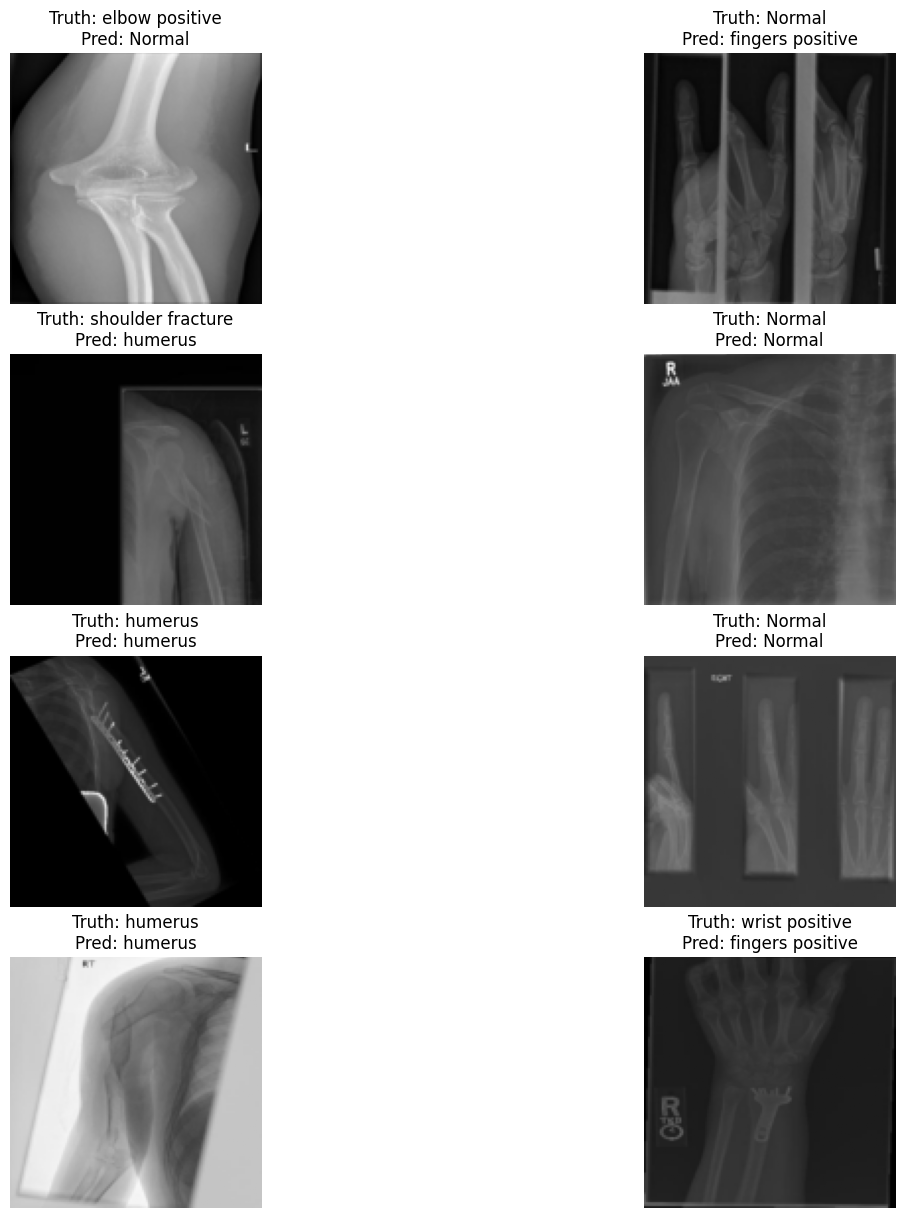

In [39]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_predictions(model, dataloader, class_names, device, n_images=8):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(n_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Truth: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                plt.imshow(inputs[j].cpu().permute(1, 2, 0).numpy())

                if images_so_far == n_images:
                    return

plot_predictions(model_3, test_dataloader, class_names, device)


In [47]:
import gradio as gr

preprocess = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),  
    transforms.ToTensor(),  
])

def predict(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    image = preprocess(image_path).unsqueeze(0).to(device) 

    with torch.no_grad():
        outputs = model_3(image) 
        _, predicted_idx = torch.max(outputs, 1) 

    predicted_index = predicted_idx.item()
    print(f"Predicted index: {predicted_index}")

    if predicted_index < 0 or predicted_index >= len(class_names):
        return "Index out of range"

    return class_names[predicted_index]

iface = gr.Interface(fn=predict, 
                     inputs=gr.Image(type="pil"), 
                     outputs="text")

iface.launch()



Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.
